# 朴素贝叶斯模型
在本文件中共手写实现了两种不同朴素贝叶斯分类器，两类分类器均使用了Lidstone平滑
- Multinomial Navie Bayes
- Bernoulli Navie Bayes  
  
并探究了不同Lidstone系数alpha对模型表现的影响

### Naive Bayes 模型原理

**Naive Bayes（朴素贝叶斯）**是一种基于贝叶斯定理的概率分类算法。其“朴素”假设指的是假定各个特征之间是条件独立的，即给定类别的情况下，每个特征的概率分布相互独立。对于输入数据 \( X = \{x_1, x_2, ..., x_n\} \)，朴素贝叶斯模型通过最大化条件概率 \( P(Y|X) \) 预测目标类别 \( Y \)，其核心思想可以用以下公式表示：

\[
P(Y|X) = \frac{P(Y) \cdot \prod_{i=1}^n P(x_i|Y)}{P(X)}
\]

其中 \( P(Y|X) \) 表示给定输入 \( X \) 的类别 \( Y \) 的后验概率。模型通常通过最大化 \( P(Y|X) \) 来选择类别，即选择具有最大概率的类别作为预测结果。

### 多项式 Naive Bayes 与伯努利 Naive Bayes 的区别

1. **多项式 Naive Bayes (Multinomial Naive Bayes)**：
   - 假定特征是离散的计数值（如词频）。适用于词袋模型中的词频或特征出现的次数。
   - 在条件概率估计中，假设每个特征值的概率与类别的条件概率成比例。因此适合处理文本数据中的词频分布。

2. **伯努利 Naive Bayes (Bernoulli Naive Bayes)**：
   - 假定特征是二值的（存在或不存在）。在每个类别下，特征的取值为“1”或“0”，分别表示特征的出现和缺失。
   - 适用于稀疏特征和文本数据中关键词是否出现的情况。

### Lidstone 平滑原理

Lidstone 平滑是一种通用的平滑方法，用于避免“零概率”问题。当在训练数据中某些特征从未出现过时，计算概率时会导致零概率。Lidstone 平滑为每个特征值添加一个平滑常数 \( \alpha \)，公式如下：

\[
P(x_i|Y) = \frac{\text{count}(x_i, Y) + \alpha}{\text{count}(Y) + \alpha \cdot N}
\]

其中 \( N \) 是特征总数。此公式确保了特征未出现时依然有概率值，有效避免了零概率问题。


### 导入必要的库 加载数据

In [1]:
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
import matplotlib.pyplot as plt

# 加载数据
with open('../datasets/train_test_data.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)


### 手写实现Multinomial Naive Bayes（采用拉普拉斯平滑，Lidstone特例）

In [2]:

# 手写 Multinomial Naive Bayes 实现
class NaiveBayesClassifier:
    def __init__(self):
        self.classes = None
        self.class_word_counts = defaultdict(lambda: np.zeros(X_train.shape[1])) # 每个类别中每个词的出现次数
        self.class_counts = defaultdict(int)# 每个类别的出现次数
        self.total_word_counts = np.zeros(X_train.shape[1])# 所有词的出现次数
        self.total_count = 0# 样本总数

    def fit(self, X, y):
        self.classes = np.unique(y)
        for x_vec, label in zip(X, y):
            self.class_word_counts[label] += x_vec
            self.class_counts[label] += 1
            self.total_word_counts += x_vec
            self.total_count += 1

    def predict(self, X):
        predictions = []
        for x_vec in X:
            class_probs = {}
            for cls in self.classes:
                # 计算类别的先验概率
                log_prob = np.log(self.class_counts[cls] / self.total_count)
                # 计算每个词的条件概率
                word_prob = np.log((self.class_word_counts[cls] + 1) / 
                                   (self.class_counts[cls] + X.shape[1])) # 拉普拉斯平滑
                log_prob += np.sum(x_vec * word_prob)
                class_probs[cls] = log_prob
            # 选择概率最大的类别作为预测结果
            predictions.append(max(class_probs, key=class_probs.get))
        return np.array(predictions)

# 训练并评估手写的 Naive Bayes
hw_nb = NaiveBayesClassifier()
hw_nb.fit(X_train, y_train)
y_pred_hw = hw_nb.predict(X_test)

# 计算手写模型的评估指标
accuracy_hw = accuracy_score(y_test, y_pred_hw)
f1_hw = f1_score(y_test, y_pred_hw)
precision_hw = precision_score(y_test, y_pred_hw)
recall_hw = recall_score(y_test, y_pred_hw)


print("Handwritten Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_hw))
print('accuracy: {}'.format(accuracy_hw))
print('f1: {}'.format(f1_hw))
print('precision: {}'.format(precision_hw))
print('recall: {}'.format(recall_hw))

Handwritten Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       896
           1       1.00      0.68      0.81       138

    accuracy                           0.96      1034
   macro avg       0.98      0.84      0.89      1034
weighted avg       0.96      0.96      0.95      1034

accuracy: 0.9574468085106383
f1: 0.810344827586207
precision: 1.0
recall: 0.6811594202898551


<Figure size 800x600 with 0 Axes>

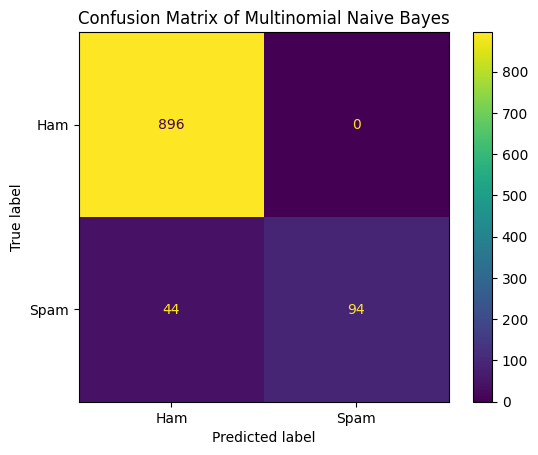

In [3]:
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred_hw)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
disp.plot()
plt.title("Confusion Matrix of Multinomial Naive Bayes")
plt.show()

### 手写Multinomial Naive Bayes 分类器改进，加入Lidstone 平滑，可调节平滑系数alpha

In [4]:
# 手写 Naive Bayes 分类器改进，加入Lidstone 平滑，可调节平滑系数alpha
class NaiveBayesClassifierWithLidstone:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # 定义平滑系数
        self.classes = None
        self.class_word_counts = defaultdict(lambda: np.zeros(X_train.shape[1]))
        self.class_counts = defaultdict(int)
        self.total_word_counts = np.zeros(X_train.shape[1])
        self.total_count = 0

    def fit(self, X, y):
        self.classes = np.unique(y)
        for x_vec, label in zip(X, y):
            self.class_word_counts[label] += x_vec
            self.class_counts[label] += 1
            self.total_word_counts += x_vec
            self.total_count += 1

    def predict(self, X):
        predictions = []
        for x_vec in X:
            class_probs = {}
            for cls in self.classes:
                # 计算类别的先验概率
                log_prob = np.log(self.class_counts[cls] / self.total_count)
                # 带有 alpha 平滑系数的条件概率计算
                word_prob = np.log((self.class_word_counts[cls] + self.alpha) / 
                                   (self.class_counts[cls] + self.alpha * X.shape[1]))
                log_prob += np.sum(x_vec * word_prob)
                class_probs[cls] = log_prob
            # 选择概率最大的类别作为预测结果
            predictions.append(max(class_probs, key=class_probs.get))
        return np.array(predictions)

# 使用平滑系数 alpha 进行训练和评估
nb_classifier_alpha = NaiveBayesClassifierWithLidstone(alpha=0.5)  # 调整 alpha 值
nb_classifier_alpha.fit(X_train, y_train)
y_pred_alpha = nb_classifier_alpha.predict(X_test)

# 计算评估指标
accuracy_alpha = accuracy_score(y_test, y_pred_alpha)
f1_alpha = f1_score(y_test, y_pred_alpha)
precision_alpha = precision_score(y_test, y_pred_alpha)
recall_alpha = recall_score(y_test, y_pred_alpha)

# 打印分类报告
print("Handwritten Naive Bayes with alpha=0.5 Classification Report:")
print(classification_report(y_test, y_pred_alpha))

# 输出各项指标
print("\nMetrics with alpha=0.5:")
print(f"Accuracy: {accuracy_alpha}")
print(f"F1 Score: {f1_alpha}")
print(f"Precision: {precision_alpha}")
print(f"Recall: {recall_alpha}")


Handwritten Naive Bayes with alpha=0.5 Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       896
           1       1.00      0.83      0.90       138

    accuracy                           0.98      1034
   macro avg       0.99      0.91      0.95      1034
weighted avg       0.98      0.98      0.98      1034


Metrics with alpha=0.5:
Accuracy: 0.97678916827853
F1 Score: 0.9047619047619047
Precision: 1.0
Recall: 0.8260869565217391


<Figure size 800x600 with 0 Axes>

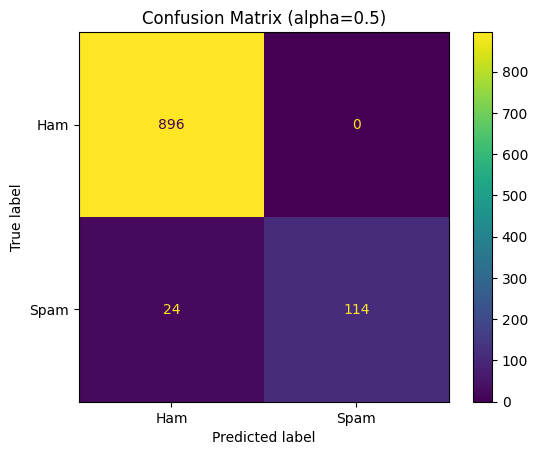

In [5]:
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred_alpha)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
disp.plot()
plt.title("Confusion Matrix (alpha=0.5)")
plt.show()

# 探索不同 alpha 值对Multinomial NB模型表现的影响

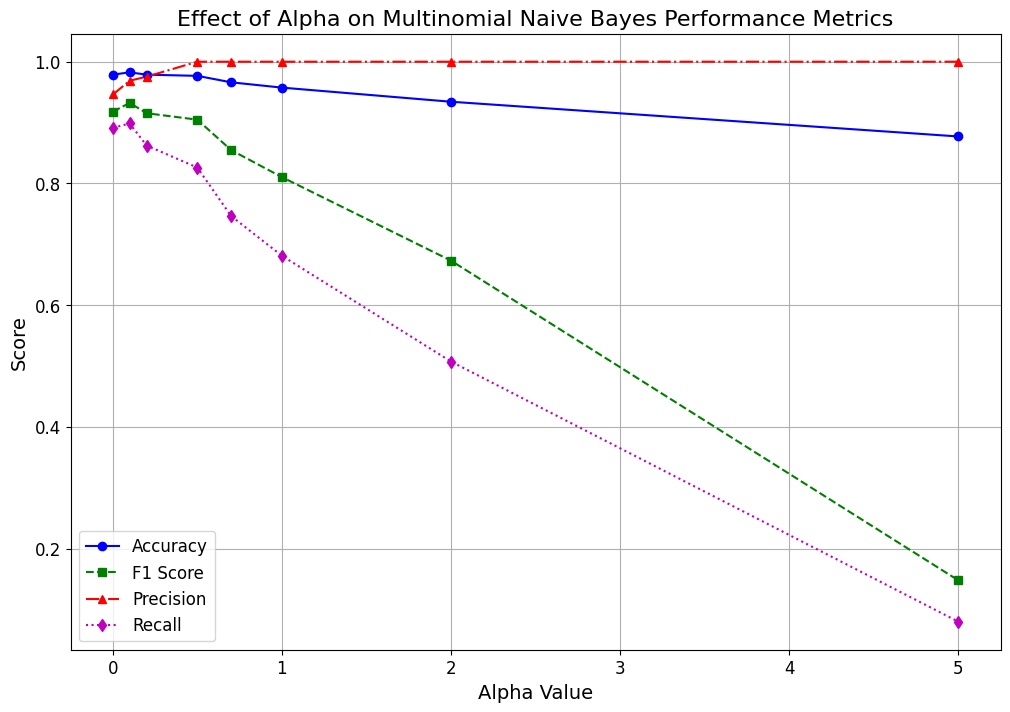

In [6]:
# 探索不同 alpha 值对模型表现的影响
alpha_values = [0.001, 0.1, 0.2, 0.5, 0.7, 1.0, 2.0 ,5.0]
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for alpha in alpha_values:
    nb_classifier = NaiveBayesClassifierWithLidstone(alpha=alpha)
    nb_classifier.fit(X_train, y_train)
    y_pred = nb_classifier.predict(X_test)
    
    # 计算每个 alpha 值下的指标
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))

# 绘图显示不同 alpha 值下的各项指标表现
plt.figure(figsize=(12, 8))
plt.plot(alpha_values, accuracy_scores, label='Accuracy', marker='o', linestyle='-', color='b')
plt.plot(alpha_values, f1_scores, label='F1 Score', marker='s', linestyle='--', color='g')
plt.plot(alpha_values, precision_scores, label='Precision', marker='^', linestyle='-.', color='r')
plt.plot(alpha_values, recall_scores, label='Recall', marker='d', linestyle=':', color='m')
plt.xlabel('Alpha Value', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Effect of Alpha on Multinomial Naive Bayes Performance Metrics', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### 手写实现 Bernoulli Naive Bayes分类器，采用Lidstone 平滑

In [7]:

class BernoulliNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # 平滑系数
        self.classes = None
        self.class_feature_counts = None  # 每个类别下特征出现的计数
        self.class_counts = None  # 每个类别的计数
        self.total_count = 0

    def binarize(self, X):
        """将特征二值化，非零值变为 1"""
        return np.where(X > 0, 1, 0)
    
    def fit(self, X, y):
        X = self.binarize(X)  # 将特征二值化
        self.classes = np.unique(y)
        self.class_feature_counts = defaultdict(lambda: np.zeros(X.shape[1]))
        self.class_counts = defaultdict(int)
        
        # 统计每个类别的特征出现次数和类别的总计数
        for x_vec, label in zip(X, y):
            self.class_feature_counts[label] += x_vec
            self.class_counts[label] += 1
            self.total_count += 1

    def predict(self, X):
        X = self.binarize(X)  # 将特征二值化
        predictions = []
        
        for x_vec in X:
            class_probs = {}
            for cls in self.classes:
                # 计算先验概率
                log_prob = np.log(self.class_counts[cls] / self.total_count)
                
                # 计算条件概率（带平滑）
                feature_prob = (self.class_feature_counts[cls] + self.alpha) / \
                               (self.class_counts[cls] + 2 * self.alpha)# Lidstone 平滑
                
                # 使用对数计算，避免乘法下溢
                log_prob += np.sum(x_vec * np.log(feature_prob) + 
                                   (1 - x_vec) * np.log(1 - feature_prob))
                class_probs[cls] = log_prob
            
            # 选择具有最高概率的类别
            predictions.append(max(class_probs, key=class_probs.get))
        
        return np.array(predictions)

bernoulli_nb = BernoulliNaiveBayes(alpha=1.0)
bernoulli_nb.fit(X_train, y_train)
y_pred = bernoulli_nb.predict(X_test)


# 计算评估指标
accuracy_Ber = accuracy_score(y_test, y_pred)
f1_Ber = f1_score(y_test, y_pred)
precision_Ber = precision_score(y_test, y_pred)
recall_Ber = recall_score(y_test, y_pred)

# 打印分类报告
print("Bernoulli Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred))
print(f"accuracy: {accuracy_Ber}")
print(f"f1 Score: {f1_Ber}")
print(f"precision: {precision_Ber}")
print(f"recall: {recall_Ber}")


Bernoulli Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       896
           1       0.99      0.88      0.93       138

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

accuracy: 0.9835589941972921
f1 Score: 0.9348659003831418
precision: 0.991869918699187
recall: 0.8840579710144928


<Figure size 800x600 with 0 Axes>

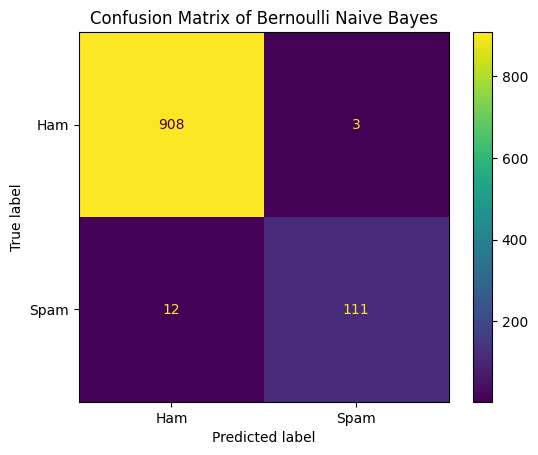

In [8]:
# 计算混淆矩阵
cm = confusion_matrix(y_pred, y_pred_alpha)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
disp.plot()
plt.title("Confusion Matrix of Bernoulli Naive Bayes")
plt.show()

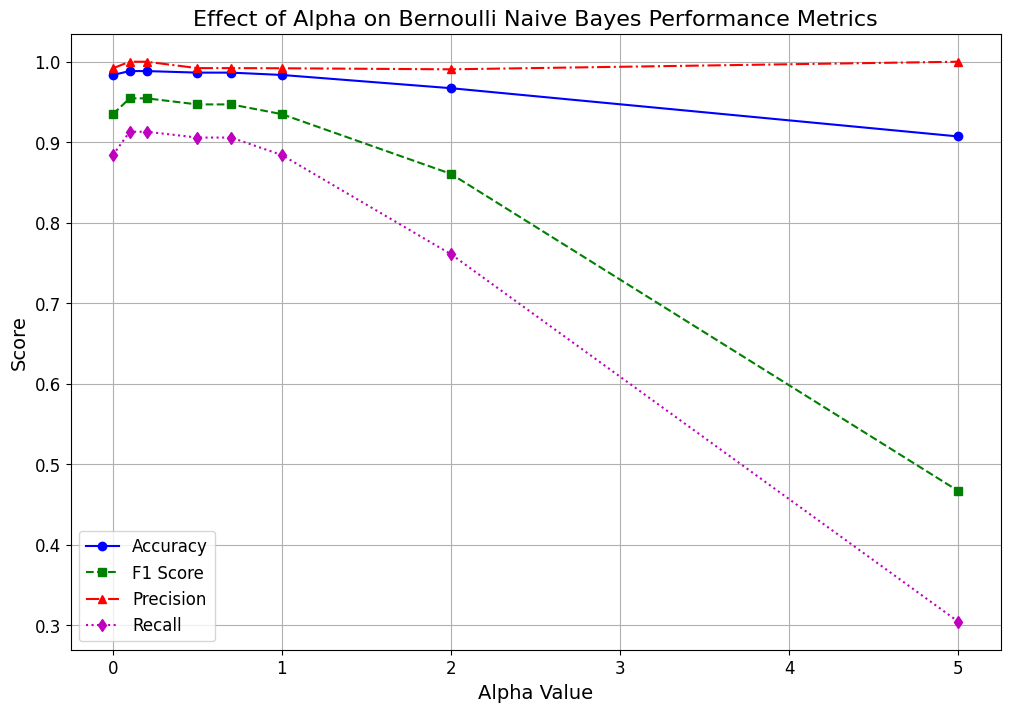

In [9]:
# 探索不同 alpha 值对模型表现的影响
alpha_values = [0.001, 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0]
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for alpha in alpha_values:
    nb_classifier = BernoulliNaiveBayes(alpha=alpha)
    nb_classifier.fit(X_train, y_train)
    y_pred = nb_classifier.predict(X_test)
    
    # 计算每个 alpha 值下的指标
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))


# 绘图显示不同 alpha 值下的各项指标表现
plt.figure(figsize=(12, 8))
plt.plot(alpha_values, accuracy_scores, label='Accuracy', marker='o', linestyle='-', color='b')
plt.plot(alpha_values, f1_scores, label='F1 Score', marker='s', linestyle='--', color='g')
plt.plot(alpha_values, precision_scores, label='Precision', marker='^', linestyle='-.', color='r')
plt.plot(alpha_values, recall_scores, label='Recall', marker='d', linestyle=':', color='m')
plt.xlabel('Alpha Value', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Effect of Alpha on Bernoulli Naive Bayes Performance Metrics', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### sklearn 库中的 Multinomial Naive Bayes 和 Bernoulli Naive Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB
# sklearn 库中的 Multinomial Naive Bayes
sklearn_nb = MultinomialNB()   
sklearn_nb.fit(X_train, y_train)
y_pred_sklearn = sklearn_nb.predict(X_test)

# 计算sklearn模型的评估指标
accuracy_MNB = accuracy_score(y_test, y_pred_sklearn)
f1_MNB = f1_score(y_test, y_pred_sklearn)
precision_MNB = precision_score(y_test, y_pred_sklearn)
recall_MNB = recall_score(y_test, y_pred_sklearn)

# 输出分类报告和评估指标
print("Sklearn Naive Bayes Classification Report with alpha=0.5 :")
print(classification_report(y_test, y_pred_sklearn))

print('sklearn Multinomial Naive Bayes accuracy: {}'.format(accuracy_MNB))
print('sklearn Multinomial Naive Bayes f1: {}'.format(f1_MNB))
print('sklearn Multinomial Naive Bayes precision: {}'.format(precision_MNB))
print('sklearn Multinomial Naive Bayes recall: {}'.format(recall_MNB))

Sklearn Naive Bayes Classification Report with alpha=0.5 :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       896
           1       1.00      0.78      0.88       138

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034

sklearn Multinomial Naive Bayes accuracy: 0.9709864603481625
sklearn Multinomial Naive Bayes f1: 0.878048780487805
sklearn Multinomial Naive Bayes precision: 1.0
sklearn Multinomial Naive Bayes recall: 0.782608695652174


In [11]:
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()  
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 计算模型的评估指标
accuracy_BNB = accuracy_score(y_test, y_pred)
f1_BNB = f1_score(y_test, y_pred)
precision_BNB = precision_score(y_test, y_pred)
recall_BNB = recall_score(y_test, y_pred)

# 打印分类报告和评估指标
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred))

print('BernouliNB Naive Bayes accuracy: {}'.format(accuracy_BNB))
print('BernouLiNB Naive Bayes f1: {}'.format(f1_BNB))
print('BernouLiNB Naive Bayes precision: {}'.format(precision_BNB))
print('BernouLiNB Naive Bayes recall: {}'.format(recall_BNB))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       896
           1       0.99      0.88      0.93       138

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

BernouliNB Naive Bayes accuracy: 0.9835589941972921
BernouLiNB Naive Bayes f1: 0.9348659003831418
BernouLiNB Naive Bayes precision: 0.991869918699187
BernouLiNB Naive Bayes recall: 0.8840579710144928


### 手写实现的模型与sklearn库中的模型表现对比

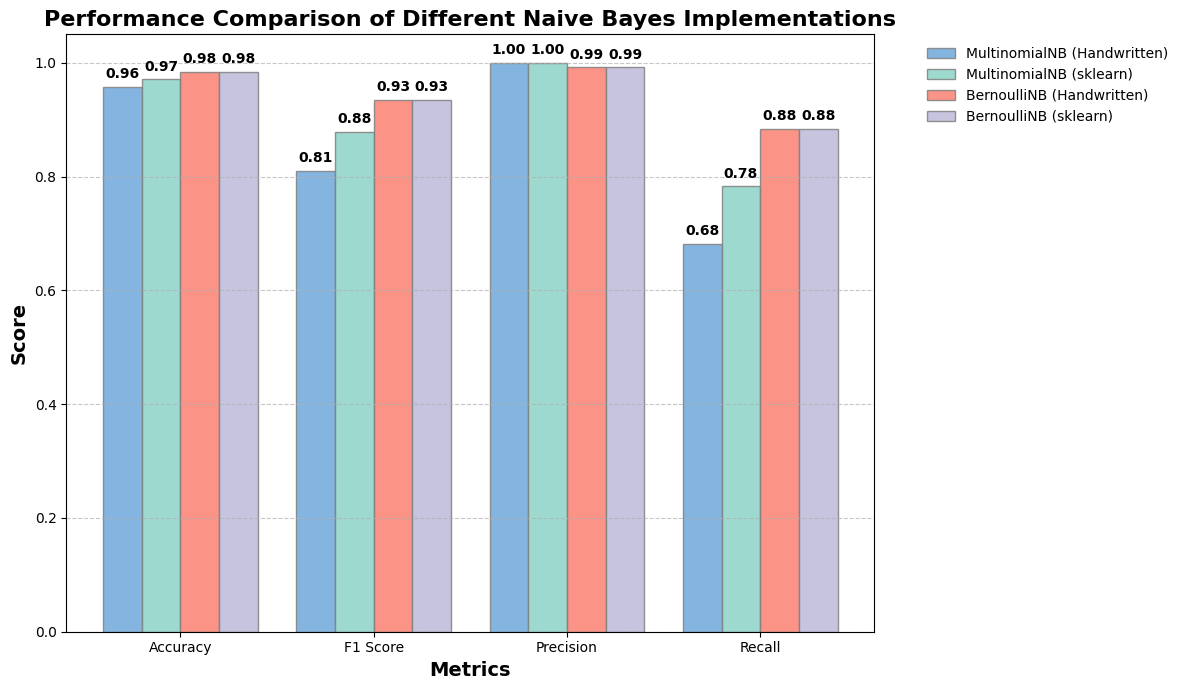

In [12]:
# 模型和 alpha 设置
model_labels = [
    'MultinomialNB (Handwritten)', 
    'MultinomialNB (sklearn)', 
    'BernoulliNB (Handwritten)', 
    'BernoulliNB (sklearn)'
]

# 假设已经计算好的每种模型的表现指标
accuracy_scores = [accuracy_hw, accuracy_MNB, accuracy_Ber, accuracy_BNB]
f1_scores = [f1_hw, f1_MNB, f1_Ber, f1_BNB]
precision_scores = [precision_hw, precision_MNB, precision_Ber, precision_BNB]
recall_scores = [recall_hw, recall_MNB, recall_Ber, recall_BNB]

# 准备绘图
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
scores = [accuracy_scores, f1_scores, precision_scores, recall_scores]

# 设置位置和宽度
x = np.arange(len(metrics))  # 为每个指标生成一个位置
width = 0.2  # 每个柱状图的宽度

# 配色
colors = ['#6fa8dc', '#8dd3c7', '#fb8072', '#bebada']

plt.figure(figsize=(12, 7))

# 绘制每个模型的柱状图，并在柱子上标上数值
for i, (label, color) in enumerate(zip(model_labels, colors)):
    bars = plt.bar(x + i * width - width * (len(model_labels) - 1) / 2, 
                   [scores[j][i] for j in range(len(metrics))], 
                   width, label=label, color=color, alpha=0.85, edgecolor='grey')
    
    # 在每个柱子上标注数值
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', 
                 fontsize=10, fontweight='bold', color='black')

# 设置图例在图外右侧
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)

# 添加网格线、轴标签和标题
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.title('Performance Comparison of Different Naive Bayes Implementations', fontsize=16, fontweight='bold')
plt.xticks(x, metrics)  # 将 x 轴设置为指标名称

plt.tight_layout()  # 自动调整布局
plt.show()
